Carga de librerías

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from numpy import abs
from matplotlib.patches import Rectangle
from geopandas.tools import geocode
from shapely.geometry import Point, LineString, Polygon

Definición de rutas relativas a archivos de datos

In [2]:
# Path a archivos de datos
ROOT = os.path.dirname(os.getcwd())
data_path = os.path.join(
    ROOT
    ,'data','Data pt1')

# Path a archivos generados en script
out_path = os.path.join(
    ROOT
    ,'data','outputs','chp04')

# Geopandas

_Geopandas_ es una extensión de `pandas` que incorpora funciones para soportar las estructuras de datos necesarias para trabajar con datos espaciales. Dentro de las funciones centrales de _Geopandas_ se encuentran:

* [Lectura y escritura de datos](#Lectura-y-escritura-de-datos)
    * [Filtros](#Filtros)
* [Estructuras de datos espaciales](#Estructuras-de-datos-espaciales)
* [Gestión de proyecciones](#Gestión-de-proyecciones)
* [Visualización de datos espaciales](#Visualización-de-datos-espaciales)
* [Transformación de datos](#Transformación-de-datos)
* [Geocoding](#Geocoding)

# Lectura y escritura de datos

Geopandas soporta de forma nativa la lectura y escritura de casi cualquier formato de datos tipo vector, ya sean _ESRI shapefile_ or _GeoJSON_. Para leer se utilizan los siguientes comandos:

In [3]:
# Lectura de datos
capitals = gpd.read_file(
    filename=os.path.join(data_path, 'Graticule', 'ne_110m_graticules_10.shp')
    ,driver='shapefile')

capitals.head(3)

,degrees,direction,display,scalerank,dd,geometry
0,80,N,80 N,4,80,"LINESTRING (180.00000 79.99848, 179.99664 79.9..."
1,70,N,70 N,4,70,"LINESTRING (180.00000 69.99847, 179.99664 69.9..."
2,60,N,60 N,4,60,"LINESTRING (180.00000 59.99866, 179.99664 59.9..."


También tiene soporte para leer archivos en línea:

In [4]:
# Lectura desde url
url = 'https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_admin_1_states_provinces_shp.geojson'
us_states = gpd.read_file(url)

us_states.head(3)

,scalerank,adm1_code,diss_me,adm1_cod_1,iso_3166_2,wikipedia,sr_sov_a3,sr_adm0_a3,iso_a2,adm0_sr,...,area_sqkm,sameascity,labelrank,featurec_1,admin,name_len,mapcolor9,mapcolor13,featureclass,geometry
0,2,USA-3514,3514,USA-3514,US-MN,http://en.wikipedia.org/wiki/Minnesota,US1,USA,US,1,...,0,-99,0,Admin-1 scale rank,United States of America,9,1,1,Admin-1 scale rank,"POLYGON ((-89.59941 48.01027, -89.48888 48.013..."
1,2,USA-3515,3515,USA-3515,US-MT,http://en.wikipedia.org/wiki/Montana,US1,USA,US,1,...,0,-99,0,Admin-1 scale rank,United States of America,7,1,1,Admin-1 scale rank,"POLYGON ((-111.19419 44.56116, -111.29155 44.7..."
2,2,USA-3516,3516,USA-3516,US-ND,http://en.wikipedia.org/wiki/North_Dakota,US1,USA,US,1,...,0,-99,0,Admin-1 scale rank,United States of America,12,1,1,Admin-1 scale rank,"POLYGON ((-96.60136 46.35136, -96.53891 46.199..."


De igual manera, soporta leer archivos comprimidos sin necesidad de descomprimirlos explícitamente:

In [5]:
# Reading in data stored in a zipped file
us_cbsas = gpd.read_file(
    filename=os.path.join(data_path, 'tl_2021_us_cbsa.zip'))

us_cbsas.head(3)

,CSAFP,CBSAFP,GEOID,NAME,NAMELSAD,LSAD,MEMI,MTFCC,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,122,12020,12020,"Athens-Clarke County, GA","Athens-Clarke County, GA Metro Area",M1,1,G3110,2654607902,26109459,+33.9439840,-083.2138965,"POLYGON ((-83.36003 34.04057, -83.36757 34.043..."
1,122,12060,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,G3110,22495873026,386782308,+33.6937280,-084.3999113,"POLYGON ((-84.27014 32.99101, -84.27084 32.991..."
2,428,12100,12100,"Atlantic City-Hammonton, NJ","Atlantic City-Hammonton, NJ Metro Area",M1,1,G3110,1438775279,301270067,+39.4693555,-074.6337591,"POLYGON ((-74.58640 39.30989, -74.58665 39.309..."


## Filtros

A partir de la versión 0.7.0 de Geopandas, se incorporaron funcionalidades para **filtrar un conjunto de datos** a partir de diferentes criterios, dentro de los cuales destaca el filtro por la **intersección espacial** con otro objeto. Existen diversos enfoques para conseguirlo, dentro de los cuales algunos de los más comunes son los siguientes:

### Filtro basado en máscaras

Este enfoque utiliza la misma lógica de máscaras que se usaría en `pandas` de manera convencional adaptado a datos espaciales. Lo primero es definir un objeto que funcionará como máscara, por ejemplo, el polígono asociado al estado de california:

In [6]:
# Lectura de datos desde archivo zip
us_states = gpd.read_file(
    filename=os.path.join(data_path, 'tl_2021_us_state.zip'))

# Definición de máscara y filtro de datos
mask = us_states['NAME'] == 'California'
california = us_states[mask] 

california.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
13,4,9,06,01779778,06,CA,California,00,G4000,A,403671756816,20293573058,+37.1551773,-119.5434183,"MULTIPOLYGON (((-116.10617 32.61848, -116.1085..."


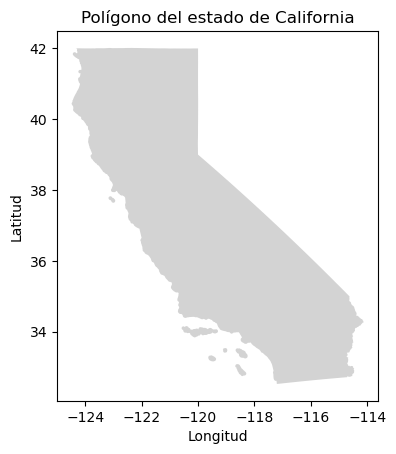

In [7]:
# Configuraciones de figura
fig, ax = plt.subplots()

# Elementos de visualización
california.plot(ax=ax, color="lightgray")

# Anotaciones y estilo
ax.set(
    xlabel="Longitud"
    ,ylabel="Latitud"
    ,title="Polígono del estado de California")

plt.show()

Una vez que se definió una máscara, y dado que los conjuntos de datos espaciales a menudo son conjuntos grandes, se puede incorporar esta máscara desde su lectura para minimizar el riesgo de colapsar la memoria de la máquina que ejecuta un determinado análisis.

Esta funcionalidad utiliza la intersección espacial de un conjunto de datos de entrada con una máscara definida, que tiene que ser un objeto espacial típicamente un **polígono**:

In [8]:
%%time

# Carga de todo el conjunto de datos
cbsas = gpd.read_file(
    filename=os.path.join(data_path, 'tl_2021_us_cbsa.zip'))

print(f"Número de polígonos: {len(cbsas)}")

Número de polígonos: 939
CPU times: total: 5.17 s
Wall time: 5.3 s


In [9]:
%%time

# Carga del mismo conjunto de datos aplicando un filtro
ca_cbsas = gpd.read_file(
    filename=os.path.join(data_path, 'tl_2021_us_cbsa.zip')
    ,mask=california)

print(f"Número de polígonos: {len(ca_cbsas)}")

Número de polígonos: 46
CPU times: total: 781 ms
Wall time: 836 ms


Se observa que al aplicar la máscara la lectura de datos es mucho más rápida. Como se comentó, el filtro de datos se realiza utilizando la **intersección espacial** con la máscara de california, sin excluir aquellos datos que se encuentran en el límite del estado. Por esta razón, hay polígonos que caen en la periferia de California:

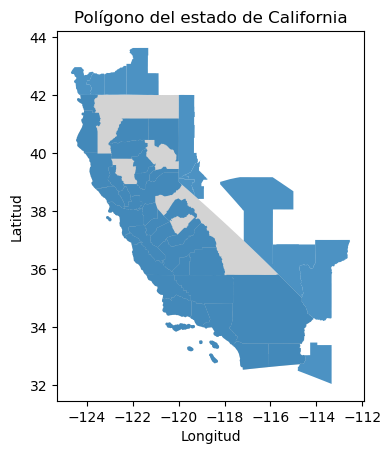

In [10]:
# Configuraciones de figura
fig, ax = plt.subplots()

# Elementos de visualización
california.plot(ax=ax, color='lightgray')
ca_cbsas.plot(ax=ax, alpha=0.8)

# Anotaciones y estilo
ax.set(
    xlabel='Longitud'
    ,ylabel='Latitud'
    ,title='Polígono del estado de California')

plt.show()

### Filtro basado en bbox

No obstante con lo descrito anteriormente, a partir de la versión 0.1.0 de _Geopandas_ se incorporaron funciones para filtrar utilizando **bounding boxes**. Un _bounding box_ es un polígono típicamente rectangular que encapsula otro objeto. 

Para conseguirlo, primero es necesario definir los límites del objeto **bbox** como un vector con dos pares de coordenadas (`lon`, `lat`, `lon`, `lat`) que representan tanto la esquina superior izquierda como la esquina inferior derecha del objeto. Con lo anterior, se puede retomar el caso de California:

In [11]:
%%time

# Definición de bbox
bounding_box = (-124, 42, -120, 38)
bbox_origen = (bounding_box[0], bounding_box[-1])

# ---- Valor absoluto de la diferencia de latitudes
bbox_height = abs(bounding_box[1] - bounding_box[-1])

# ---- Valor absolutdo de la diferencia de longitudes
bbox_width = abs(bounding_box[-2] - bounding_box[0])

# Carga del conjunto de datos filtrando por bbox
cbsas_bbox = gpd.read_file(
    filename=os.path.join(data_path, 'tl_2021_us_cbsa.zip')
    ,bbox=bounding_box)

print(f"Número de polígonos: {len(cbsas_bbox)}")

Número de polígonos: 24
CPU times: total: 547 ms
Wall time: 631 ms


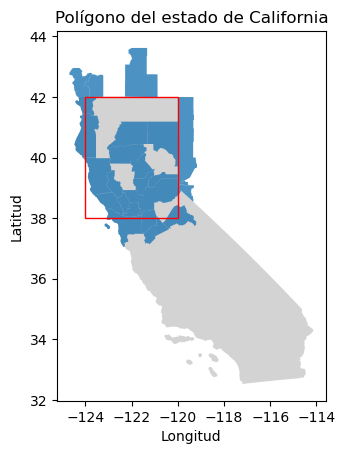

In [12]:
# Configuraciones de figura
fig, ax = plt.subplots()

# Elementos de visualización
california.plot(ax=ax, color='lightgray')
cbsas_bbox.plot(ax=ax, alpha=0.8)
bbox_vis = Rectangle(
    xy=bbox_origen
    ,width=bbox_width
    ,height=bbox_height
    ,color='red'
    ,fill=False)
ax.add_patch(bbox_vis)

# Anotaciones y estilo
ax.set(
    xlabel='Longitud'
    ,ylabel='Latitud'
    ,title='Polígono del estado de California')

plt.show()

En este caso, el filtro también es utilizando la **intersección espacial** de un conjunto de entrada con un polígono **bbox** definido previamente. Al igual que en el filtro por máscaras, los polígonos que regresa el filtro incluyen aquellos que están en el límite del _bounding box_

## Escritura de datos

Para la escritura de datos es necesario proporcionar el _path_ del archivo que se va a almacenar, así como el _driver_ de la extensión de archivo que se utilizará. Las extensiones más comunes para escritura son _shapefile_ y _geojson_.

In [13]:
# Escritura como shapefile
ca_cbsas.to_file(
    filename=os.path.join(out_path, 'ca_cbsas.shp')
    ,driver='Shapefile')

# Escritura como geojson
cbsas_bbox.to_file(
    filename=os.path.join(out_path, 'cbsas_bbox.geojson')
    ,driver="GeoJSON")

# Estructuras de datos espaciales

Cuando se utiliza _Geopandas_ las dos estructuras de datos más comunes son el **GeoDataFrame** y la **GeoSeries** que son subclases de las _Series_ y _DataFrame_ convencionales de `pandas`.

La _GeoSerie_ se puede pensar como un vector columna, en donde cada elemento del vector es una forma que corresponde a una observación, y que pueden ser puntos, líneas , o polígonos. Los atributos y métodos de clase que se pueden utilizar con estos objetos son:

**Atributos**:

* `area()`: Proporciona el área de la geometría
* `geom_type()`: Provee el tipo de geometría de cada elemento en la _GeoSerie_
* `bounds()`: Tupla con las coordenadas mínima y máxima de cada elemento de la serie
* `total_bounds()`: Tupla con las coordenadas mínima y máxima a lo largo de toda la serie

**Métodos**:

* `to_crs()`: Cambia el sistema de referencia de coordenadas
* `distance()`: Regresa una serie con la distancia mínima de cada entrada a las demás entradas de la serie
* `centroid()`: Regresa el centroide de cada elemento en la serie

Las _GeoSeries_ también pueden desempeñar pruebas basadas en la relación espacial con otras entradas, que pueden ser pruebas de adyacencia, contigüidad, traslape. y proximidad entre entradas. Las dos principales pruebas basadas en la relación espacial entre entradas son:

* `intersects()`: Evalúa si dos objetos se intersectan o tienen traslape entre sí
* `contains()`: Evalúa si un objeto está totalmente contenido dentro de otro

Un _GeoDrataFrame_ es entonces una colección de _GeoSeries_ que tiene una característica única, contiene una _GeoSerie_ de geometría en donde se almacena la información geométrica de cada entrada, y se puede recuperar con el atributo `geometry()`

# Gestión de proyecciones

_GeoPandas_ puede ser utilizado para administrar la proyección de los datos geoespaciales. Para cambiar la proyección es necesario llamar el método de clase `to_crs()` en alguna de las estructuras de datos que ya se mensionaron. Este método está basado en la librería `PyProj`, específicamente en el método `pyproj.crs.from_user_input()` por lo que el método de _GeoPandas_ acepta todos los argumentos del método de _PyProj_, incluyendo:

* Una cadena de texto con el **CRS**
* Un identificador numérico de **ESPG**
* La clase del objeto `PyProj`

# Visualización de datos espaciales

A lo largo del _notebook_ ya se han visto algunos ejemplos básicos de visualización de datos espaciales utilizando la librería `matplotlib`. Una forma muy simple de tener una vista previa de los objetos espaciales es utilizando funciones _magic_ de _GeoPandas_ para visualización de datos utilizando el método `plot()`

Algunos mapas que son particularmente interesantes y que se pueden construir fácilmente con este método de clase son los famosos mapas **choropleth**, que son mapas en donde el color de cada geometría del mapa está en función del valor que tome algún atributo asociado a ella, por ejemplo, el PIB, la densidad poblacional, etc.

Un ejemplo sencillo de ello es el siguiente **mapa de población mundial**:

C:\Users\Miguel\AppData\Local\Temp\ipykernel_24636\3247959822.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  filename=gpd.datasets.get_path('naturalearth_lowres'))


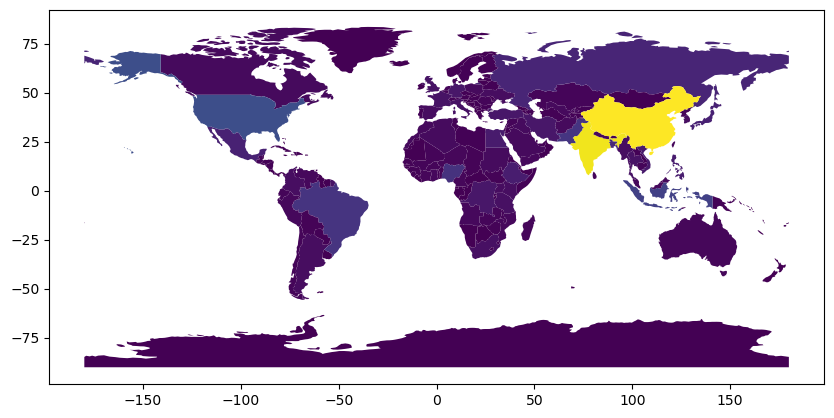

In [14]:
# Carga de datos de población
world = gpd.read_file(
    filename=gpd.datasets.get_path('naturalearth_lowres'))

# Especificaciones de figura
fig, ax = plt.subplots(figsize=(10,8))

# Elementos de visualziación
# ---- Mapa choropleth por pop_est
world.plot(column='pop_est', ax=ax)

plt.show()

# Transformación de datos

Las transformaciones de datos que se pueden realizar a conjuntos espaciales son múltiples, algunas de las más comunes se basan en funciones base de `pandas` y se describen a continuación:

* **Append**: El método de _GeoPandas_ `append()` se basa en su equivalente de _pandas_, y es utilizado para incoporar información de dos objetos a nivel de fila. Esto quiere decir que la información del segundo objeto se incorpora al final del primero objeto como nuevos registros. Es **importante** mencionar que para que este método funcione, es necesario que ambos objetos se encuentre en el mismo **CRS**
* **Join**: Se utiliza para unir dos _GeoDataFrames_ tomando como referencia un identificador único. El método `merge()` es el que funciona mejor para estos propósitos
* **Spatial Join**: Se utiliza para combinar dos _GeoDataFrames_ basándose en la relación espacial de los registros de cada uno de los conjuntos de datos. Para conseguirlo existen dos métodos que se pueden utilizar:
    * `sjoin()`: Hace la unión con resultados booleanos como pudieran ser `intersect()` o `contains()`
    * `sjoin_nearest()`: Hace la unión basado en la cercanía entre observaciones
* **Centroid**: Regresa una _GeoSeries_ con los centroides de los objetos geométricos que se le proporcionan

Otras transformaciones que se pueden realizar (y que vale la pena ejemplificar) son las siguientes:

## Buffer

Toma una distancia como parámetro de entrada, y regresa una _GeoSeries_ de geometrías que representan aquellos puntos que están dentro de la distancia dada al objeto en cuestión

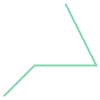

In [15]:
# Iniciar objeto espacial con tres tipos de geometrías
s = gpd.GeoSeries(
    data=[
        Point(1, 5)
        ,LineString([(2, -1), (3, 0), (5, 0), (4, 2)])
        ,Polygon([(5, -2), (3, 5), (5, 2)])]
)

# Visualizar la línea
s[1]

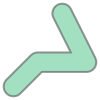

In [16]:
# Visualizar la misma línea como buffer
s_b = s.buffer(distance=0.4)
s_b[1]

## Dissolve

Se utiliza para transformar una geografía de bajo orden en una de alto orden, por ejemplo, el [mapa choropleth](#Visualización-de-datos-espaciales) que se realizó en la sección anterior tenía información desagregada a nivel de país, si se quisiera hacer el mismo análisis a nivel continente se puede utilizar el método `dissolve()` para hacer agregaciones, por ejemplo, calcular la media:

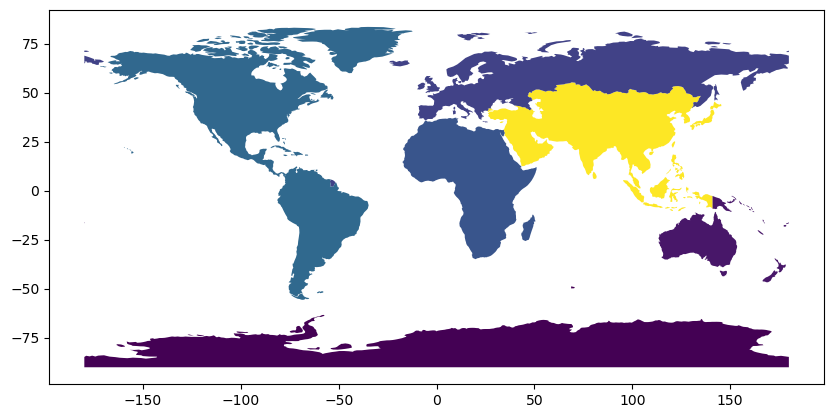

In [17]:
# Dissolve aplicado a datos mundiales
continents = world.dissolve(by="continent", aggfunc='mean', numeric_only=True)

# Especificaciones de figura
fig, ax = plt.subplots(figsize=(10,8))

# Elementos de visualziación
# ---- Mapa choropleth por pop_est
continents.plot(column='pop_est', ax=ax)

plt.show()

## Simplify

Esta transformación regresa una _GeoSeries_ que representa una versión simplificada o suavizada de alguna geometría de entrada. Esto se hace con el propósito de optimizar recursos computacionales a la hora de realizar operaciones, especialmente en análisis que no requieren tanto nivel de detalle, por ejemplo, en las costas de alguna región

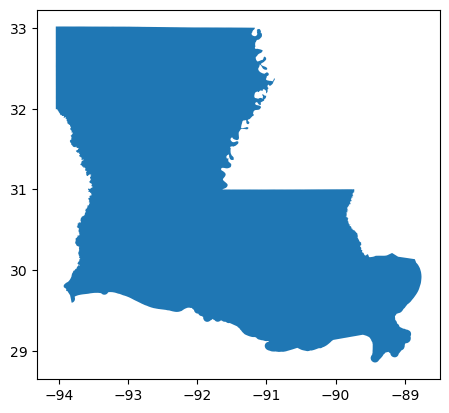

In [18]:
LA = us_states[us_states['STUSPS'] == 'LA']
LA.plot()

plt.show()

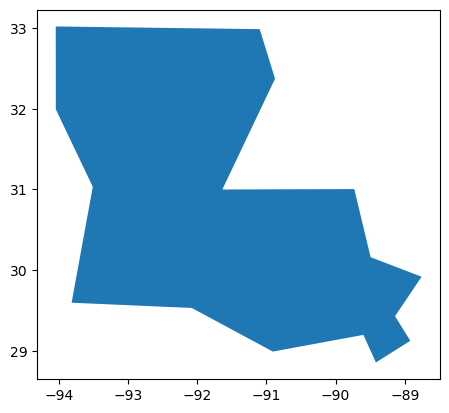

In [19]:
LA_s = LA.simplify(tolerance=0.25)
LA_s.plot()

plt.show()

# Geocoding

In [20]:
dc_attractions = pd.read_csv(
    os.path.join(data_path, 'DC_Attractions.csv'))
dc_attractions.head()

,Attraction,Address
0,Washington Monument,"2 15th St NW, Washington, DC 20024"
1,Smithsonian National Air and Space Museum,"600 Independence Ave SW, Washington, DC 20560"
2,White House,"1600 Pennsylvania Avenue NW, Washington, DC 20500"


In [21]:
# Geocode addresses using Nominatim. Remember to provide a custom "application name" in the user_agent parameter!
dc_attractions_gpd = geocode(dc_attractions['Address'], provider='openmapquest', timeout=4, api_key="API KEY")
dc_attractions_gpd.head()

GeocoderUnavailable: HTTPSConnectionPool(host='open.mapquestapi.com', port=443): Max retries exceeded with url: /nominatim/v1/search?q=2+15th+St+NW%2C+Washington%2C+DC+20024&format=json&limit=1&key=API+KEY (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)')))

In [ ]:
dc_attractions_gpd.plot()